機械学習特論 第7回 アヤメのデータのクラスタリング

In [ ]:
# google colab で実行する場合は、次の行の先頭の # を削除してこのブロックを実行する
#!pip install japanize-matplotlib
#!pip install kneed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
import kneed

(150, 5)


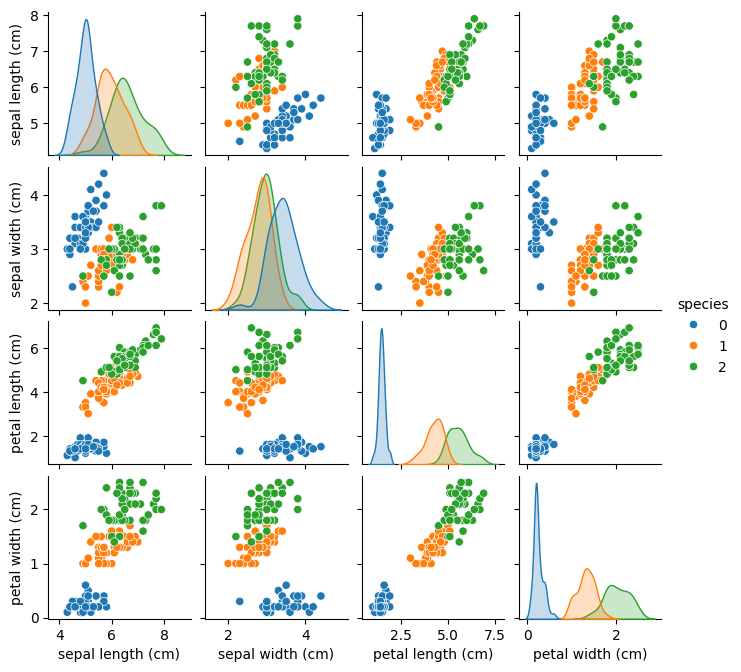

In [3]:
# sklearnデータセットに収録されたiris(アヤメ)のデータセットをロード
from sklearn.datasets import load_iris
iris_data = load_iris()

# 学習用データのデータフレームを作成
x = pd.DataFrame(iris_data["data"],columns=iris_data["feature_names"])
y = pd.DataFrame(iris_data["target"],columns=["target"])

# ペアプロットを表示
plot_data = x.copy()
plot_data['species'] = y
print(plot_data.shape)
sns.pairplot(plot_data, hue='species', palette='tab10', height=1.7)

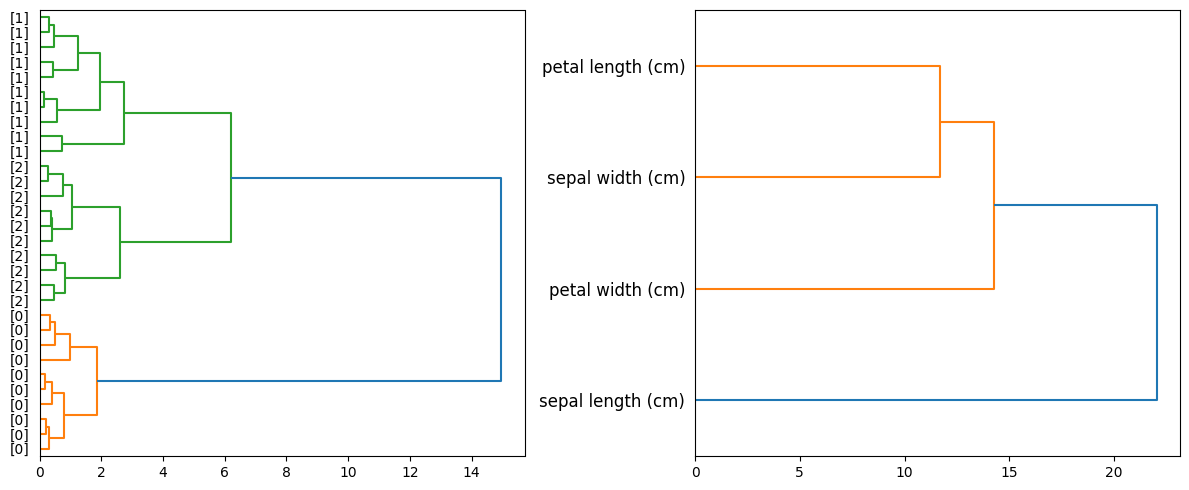

In [4]:
## 階層型クラスタリング
# データを5行間隔で間引く (表示のため)
x_mini = x.loc[::5]
y_mini = y.loc[::5]
# クラスター間の距離を計算 (ユークリッド距離を利用) してクラスターを統合 (ward法)
dist_0 = hierarchy.distance.pdist(x_mini, metric='euclidean')  # 個体ごとにクラスタリング
linkage_0 = hierarchy.linkage(dist_0, method='ward', metric='euclidean')
dist_1 = hierarchy.distance.pdist(x_mini.T, metric='euclidean') # (データを転置して)特徴量のクラスタリング
linkage_1 = hierarchy.linkage(dist_1, method='ward', metric='euclidean') 
# デンドログラムを表示
fig, ax = plt.subplots(1, 2, figsize=(12,5))
d0 = hierarchy.dendrogram(Z=linkage_0, ax=ax[0], orientation='right', labels=y_mini.values.tolist())
d1 = hierarchy.dendrogram(Z=linkage_1, ax=ax[1], orientation='right', labels=x_mini.columns)
plt.tight_layout() # ラベルの重なりを回避するため
plt.show()

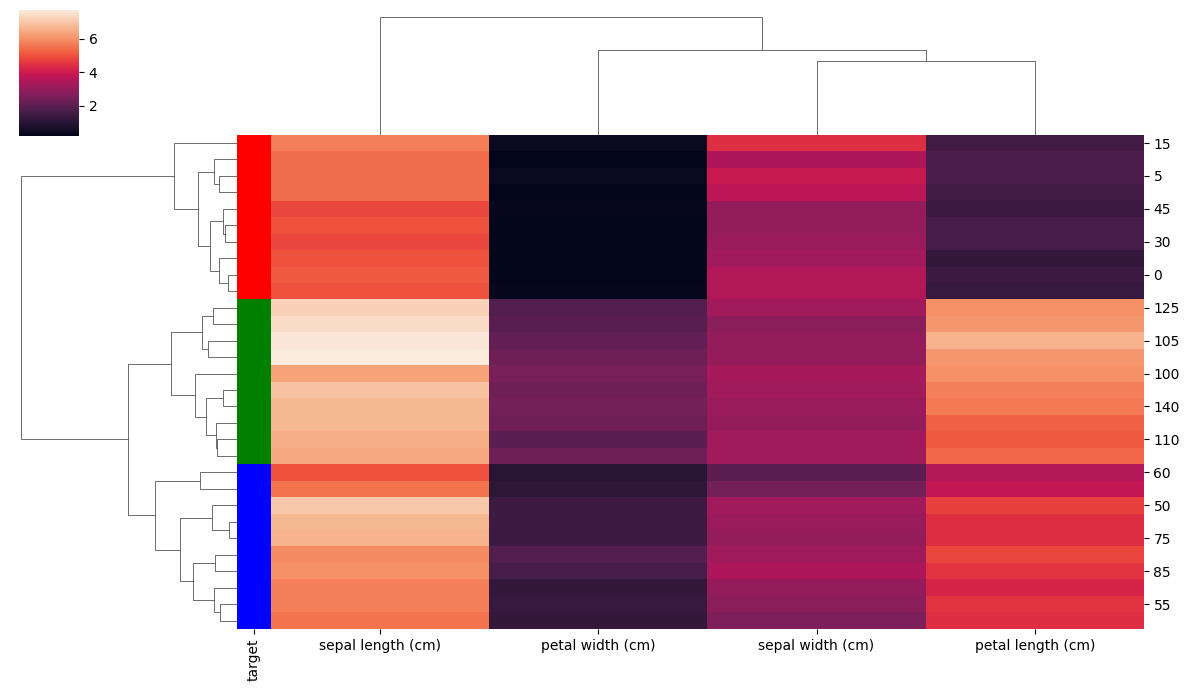

In [5]:
# クラスターマップ(ヒートマップ＋デンドログラム)を表示
lut = dict(zip(y_mini['target'].unique(), "rbg")) # 品種情報も追加表示
row_colors = y_mini['target'].map(lut)
c = sns.clustermap(x_mini, row_colors=row_colors, figsize=(12,7))

クラスターと品種が一致: 2 (0.013333333333333334)


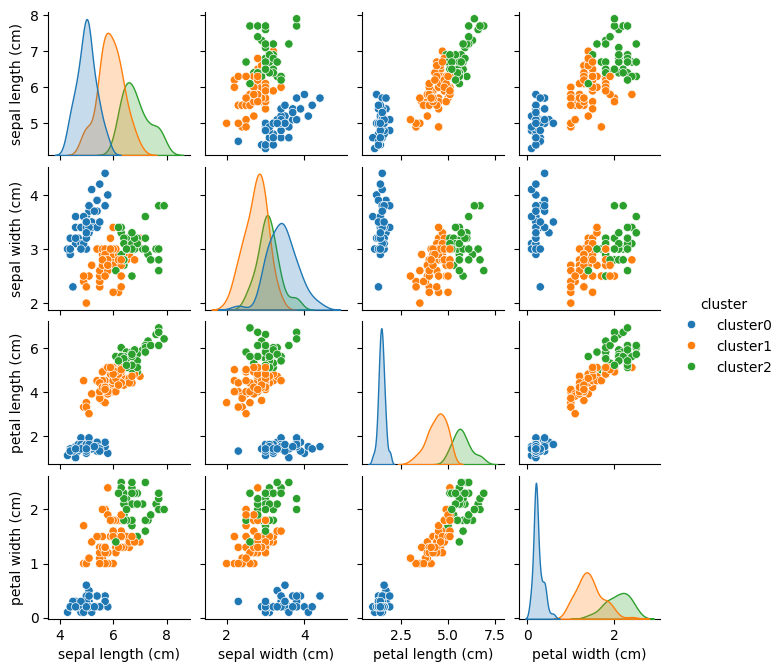

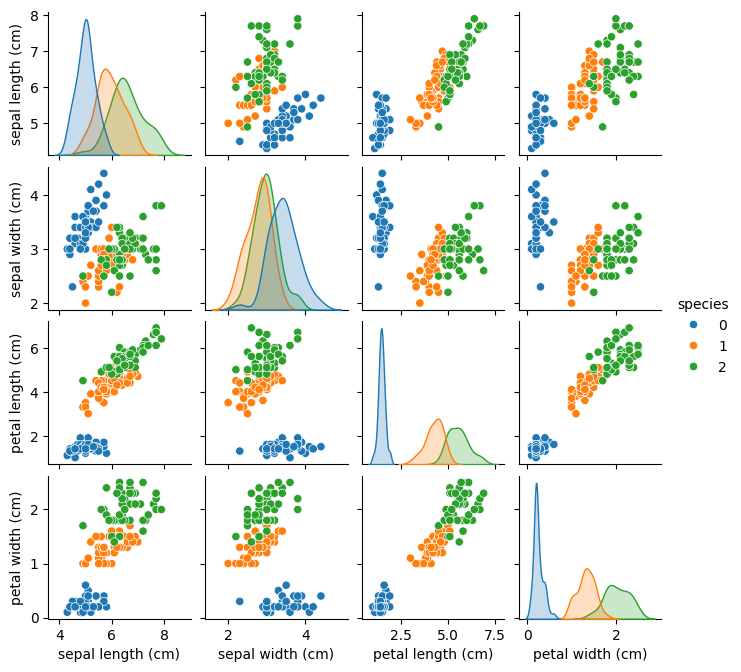

In [14]:
# kmeans法を実行
kmeans = KMeans(n_clusters=3, max_iter=30, init="random", n_init='auto', random_state=1)
cluster = kmeans.fit_predict(x)

# 結果を確認 (品種とクラスター番号の紐づけは結果を確認して実施)
correct = 0
for _y, _pred in zip(y['target'], cluster):
    if (_y == 0 and _pred == 1) or (_y == 1 and _pred == 2) or (_y == 2 and _pred == 0):
        correct = correct + 1  
print('クラスターと品種が一致:', correct, f'({correct/len(y)})')

# ペアプロットで結果を確認
kmeans_result = x.copy()
kmeans_result["cluster"] = ["cluster"+str(x) for x in cluster]
sns.pairplot(kmeans_result, hue='cluster', height=1.7)
sns.pairplot(plot_data, hue='species', palette='tab10', height=1.7)


エルボー法によるクラスター数: 3


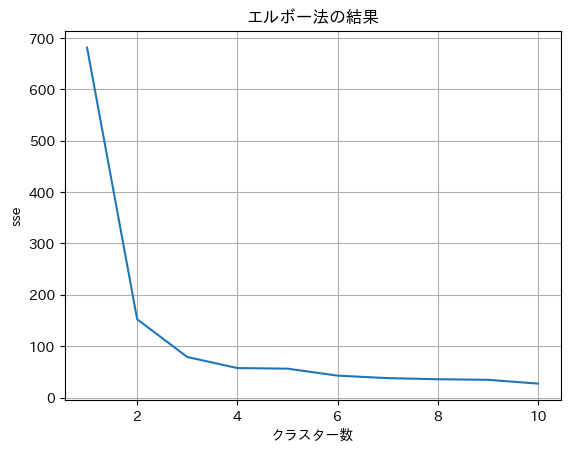

In [31]:
# クラスターの中心とデータ点の間の距離の総計を記録するリスト
sse = []

# クラスタ数を変えてSSEを計算
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=1)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

# kneedを使用してエルボーポイントを特定
kneedle = kneed.KneeLocator(k_values, sse, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow
print('エルボー法によるクラスター数:', optimal_k)

plt.plot(range(1, 11), sse)
plt.title('エルボー法の結果')
plt.xlabel('クラスター数')
plt.ylabel('sse') 
plt.grid()
plt.show()

In [33]:
# 手書き文字のデータセットをダウンロードして、実験用データを準備
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml('mnist_784', parser='auto', version=1)
mnist_x = np.array(mnist_data['data'].astype(np.float32))[::10] # 計算時間の都合からデータサイズを縮小
mnist_y = np.array(mnist_data['target'].astype(np.int32))[::10] # 70000 -> 7000

エルボー法によるクラスター数: 14


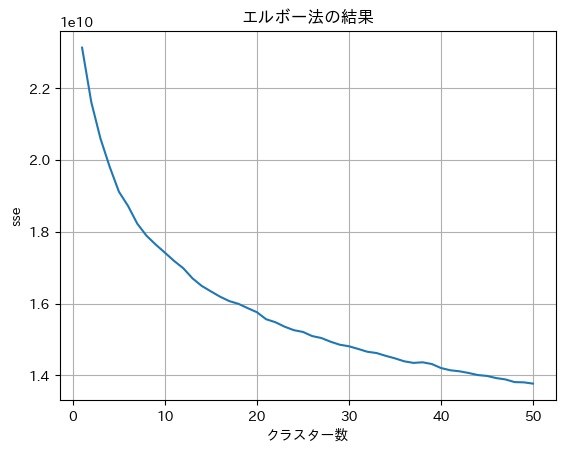

In [37]:
# クラスターの中心とデータ点の間の距離の総計を記録するリスト
sse = []

# クラスタ数を変えてSSEを計算
k_values = range(1, 51)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=1)
    kmeans.fit(mnist_x)
    sse.append(kmeans.inertia_)

# kneedを使用してエルボーポイントを特定
kneedle = kneed.KneeLocator(k_values, sse, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow

print('エルボー法によるクラスター数:', optimal_k)

# エルボーポイントをプロット
plt.plot(range(1, 51), sse)
plt.title('エルボー法の結果')
plt.xlabel('クラスター数')
plt.ylabel('sse') 
plt.grid()
plt.show()

# 求めたクラスター数でクラスタリングを実行
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=1)
mnist_optimal_k_cluster = kmeans.fit_predict(mnist_x)

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
mnist_x_reduced  = tsne.fit_transform(mnist_x)

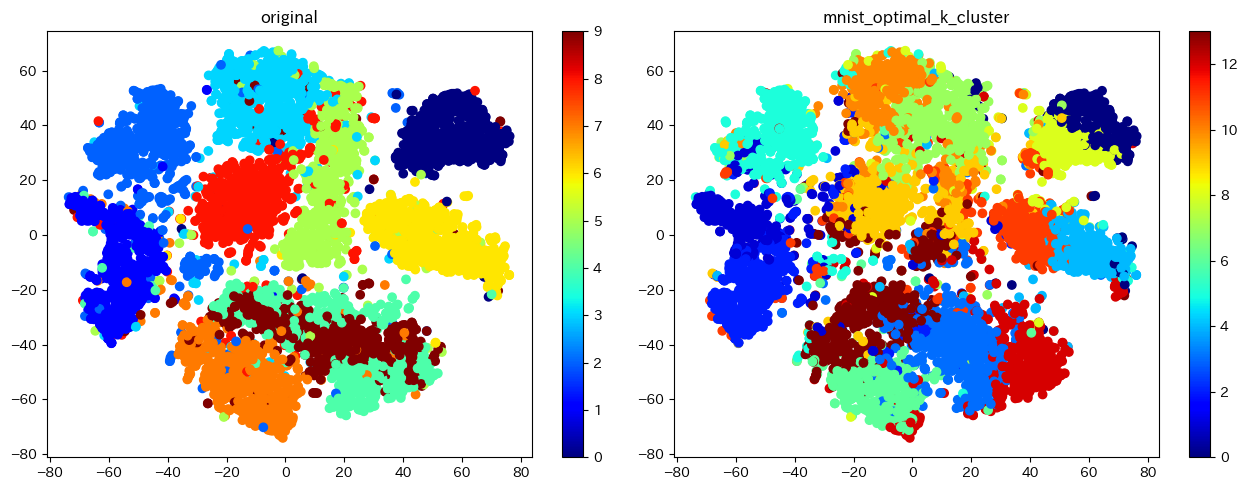

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
sc1 = ax[0].scatter(mnist_x_reduced[:, 0], mnist_x_reduced[:, 1], c=mnist_y, cmap="jet")
ax[0].set_title('original')
fig.colorbar(sc1, ax=ax[0])
sc2 = ax[1].scatter(mnist_x_reduced[:, 0], mnist_x_reduced[:, 1], c=mnist_optimal_k_cluster, cmap="jet")
ax[1].set_title('mnist_optimal_k_cluster')
fig.colorbar(sc2, ax=ax[1])
plt.tight_layout() # ラベルの重なりを回避するため
plt.show()